# Image segmentation for AB4

#### Magic lines for IPython

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Import necessary modules

In [12]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

#### Working Path/Directory - independent of OS

In [13]:
path = untar_data(os.getcwd())

In [14]:
path.ls()

[WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/.ipynb_checkpoints'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/classes.txt'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/images'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/labels'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/Solution for AB4.ipynb'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/valid.txt')]

## Data Manipulation
Split the data into images and labels, typical approach for image segmentation. Labels will represent the mask for each specific image. Classes represent the type for each pixel. 

In [15]:
path_lbl = path/'labels'
path_img = path/'images'
df_classes = pd.read_csv(path/'classes.txt')
df_classes

,Bone
0,Soft_Tissue
1,Water
2,Fat
3,Lung
4,Air
5,Void


Test that the path selected is indeed correct. Also shows the data type and path format.

In [16]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/images/107aHU.png'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/images/107bHU.png'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/images/107cHU.png')]

Same for labels. Note difference in naming, each image has a corresponding prefix for each label.

In [17]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/labels/107aseg.png'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/labels/107bseg.png'),
 WindowsPath('C:/Users/sergi/Desktop/AB4-Solution/labels/107cseg.png')]

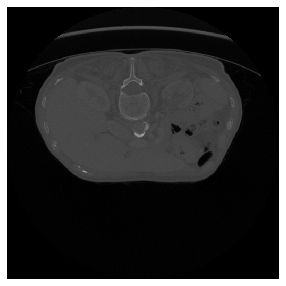

In [18]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

The function from below takes as input a Path for a specific image and returns the Path for its corresponding label.

In [19]:
def get_y_fn(x):
    if len(str(x)) - len(str(path_lbl)) == 11:
        return path_lbl/f'{x.stem[0:4]}seg{x.suffix}'
    else:
        return path_lbl/f'{x.stem[0:3]}seg{x.suffix}'

We test the function to see if it is working properly. It can be seen that the segmentation mask (organ) matches our image.

C:\Users\sergi\Desktop\AB4-Solution\images\107aHU.png
C:\Users\sergi\Desktop\AB4-Solution\labels\107aseg.png


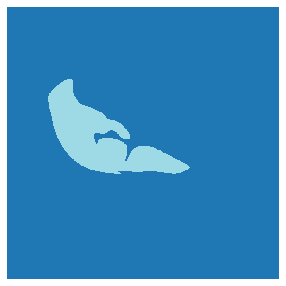

In [20]:
print(img_f)
print(get_y_fn(img_f))
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

We test sizes for corresponding image/mask data. Each pixel in our image has a specific value, corresponding in theory to a certain Hounsfield value.


In [21]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([512, 512]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

For the current solution, we only have a scope of segmenting one organ/object from the rest of the image. This brings us to a binary solution. Although that is the case, each specific organ/object has pixels in a certain Hounsfield range. This should be taken into consideration.

In [22]:
codes = np.loadtxt(path/'classes.txt', dtype=str); codes

array(['Bone', 'Soft_Tissue', 'Water', 'Fat', 'Lung', 'Air', 'Void'], dtype='<U11')

## Dataset

In [23]:
size = src_size
bs = 2

This is where we split out data into train/validation, no test. The *valid.txt* file contains name of images that will be kept for validation, so there will be no random selection of images for the validation set. We get our labels from the image (path + name).

In [24]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

We transform out data into a data bunch, which is a way of storing data for later processing within the Model. This is specific for Pytorch, with respect to Fast.ai.

In [25]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

Before going further, we check dimensions of image and labels. 
As can be seen, image has a dimension of 3x512x512, whereas label has only 1x512x512. 
We will address this issue later, with the squeeze function call.

In [26]:
data.train_ds

LabelList (12 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: C:\Users\sergi\Desktop\AB4-Solution\images

We check a sample of the Train batch.

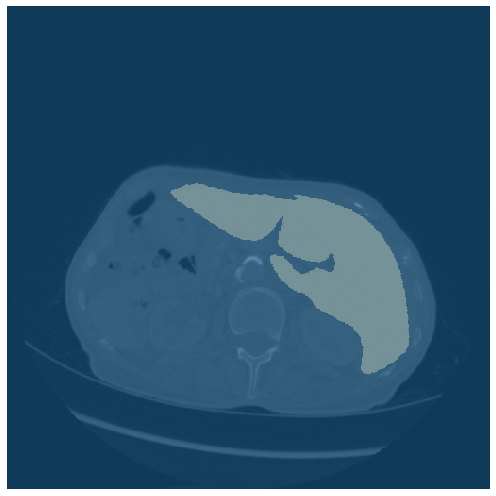

In [27]:
data.show_batch(1, figsize=(7,7))

We check a sample of the Validation batch.

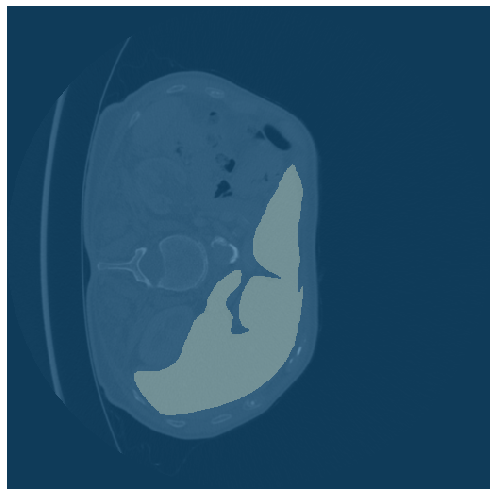

In [28]:
data.show_batch(1, figsize=(7,7), ds_type=DatasetType.Valid)

## Model

First 2 lines might not be necessary, but they are good practice. In image segmentation, some pixels might be considered of no recognizable class, so we have a void class.
The function below is inspired from the "Camvid Image Database". It is used to reduce the dimenion of samples, as was mentioned above, using the squeeze function. We bring both, the labels and images, to the same type (dimension).
After that, we try to measure our success in matching mask pixels with actual image pixels. In essence, we create a specific metric which better determines our success in our image segmentation attempt.

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics = acc_camvid

We attempt to create a model using a Neural Network, based on the famous Resnet34 architecture. We specify which data we want to use to train our NN, and how we measure our success (metrics). Now, there are many options for choosing a neural network architecture, obviously, but what distinguishes this one from others is that it comes pretrained, courtesy of PyTorch. This means that our neural network has 'some' knowledge of object detection, or image understanding in general. A more precise alternative might be Resnet50. The key difference between the 2 is the number of layers, 50 instead of 34, which might enable the model to make more precise predictions with a higher cost in speed and space overhead. All pre-existing models have the same bottleneck: They require 'large' datasets - at the very least 100 samples per category/class. Obviously, more training samples would be needed here.

In [ ]:
wd = 1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

After establishing our type of model, we want to see how it learns through the epochs, and plot the evolution of the learning rate. This way, we can better understand how to train our model. The parameter of wd comes from weight decay, which can be translated a regularization parameter. Needless to say, it is a game changer.

In [22]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
lr=1e-2

After establishing what might turn out to be a good learning rate, we attempt to fit our model over 5 epochs, with a varying learning rate, larger at the start, but smaller at the end. Rationale is purely mathematical, and is deeply connected with Gradient Descent.

In [ ]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

We save our model for further use. Further implementation might include unfreezing latter layers and retraining them for a more focused purpose.

In [ ]:
learn.save('stage-2');